## Clustering

https://towardsdatascience.com/an-efficient-implementation-of-dbscan-on-pyspark-3e2be646f57d/

In [1]:
import os
import math
import numpy as np
import pyspark.sql.functions as sql_f

from graphframes import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
from scipy.spatial import distance
from pyspark.sql.functions import col, substring
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.functions import substring
from pyspark.sql.functions import size, col
from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql import Row
from itertools import combinations

# Variable de entorno. Modificar en caso de disponer de varias
# versiones de Java instaladas.
os.environ["JAVA_HOME"] = r"/home/cristhian/Descargas/OpenJDK8U-jdk_x64_linux_hotspot_8u452b09/jdk8u452-b09"

In [2]:
# Definición del entorno de ejecución
CORES = 12 # Número de núcleos de CPU a usar
PARTS = 12 # Número de particiones del dataset (para hacer repartition)
FRAC = 1.0 # Fracción de los datos aleatoriamente seleccionados
DIMS = 14  # Número de componentes PCA seleccionadas en base a mayor varianza explicada

spark = (
    SparkSession.builder.master(f"local[{CORES}]")
    .appName(f"Local DT con {CORES} particiones")
    .config("spark.driver.memory", "24g")
    .config("spark.executor.memory", "24g")
    .config("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.2-s_2.12")

    .getOrCreate()
)
sc = spark.sparkContext
sc.setCheckpointDir("/tmp/graphframes-checkpoints")

:: loading settings :: url = jar:file:/home/cristhian/anaconda3/envs/BD_Spark/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/cristhian/.ivy2/cache
The jars for the packages stored in: /home/cristhian/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-b6a97007-8cb0-474c-8b7e-f0bf2e7a3bac;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.2-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 71ms :: artifacts dl 2ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.2-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	----------------------------

## Análisis

Explicar muy bien que podemos hacer el EDA con sklearn, ya que en principio (en la mayoría de dataset para Big Data) deberíamos hacer un sampling para poder hacerlo.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("spotify_songs.csv")

print("Tamaño: ", data.shape)
print(data.head())

Tamaño:  (32833, 23)
                 track_id                                         track_name  \
0  6f807x0ima9a1j3VPbc7VN  I Don't Care (with Justin Bieber) - Loud Luxur...   
1  0r7CVbZTWZgbTCYdfa2P31                    Memories - Dillon Francis Remix   
2  1z1Hg7Vb0AhHDiEmnDE79l                    All the Time - Don Diablo Remix   
3  75FpbthrwQmzHlBJLuGdC7                  Call You Mine - Keanu Silva Remix   
4  1e8PAfcKUYoKkxPhrHqw4x            Someone You Loved - Future Humans Remix   

       track_artist  track_popularity          track_album_id  \
0        Ed Sheeran                66  2oCs0DGTsRO98Gh5ZSl2Cx   
1          Maroon 5                67  63rPSO264uRjW1X5E6cWv6   
2      Zara Larsson                70  1HoSmj2eLcsrR0vE9gThr4   
3  The Chainsmokers                60  1nqYsOef1yKKuGOVchbsk6   
4     Lewis Capaldi                69  7m7vv9wlQ4i0LFuJiE2zsQ   

                                    track_album_name track_album_release_date  \
0  I Don't Care (with Just

In [4]:
print("Variables y sus tipos")
print(data.info())

Variables y sus tipos
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-nul

In [5]:
print("Resumen estadístico:")
print(data.describe())

Resumen estadístico:
       track_popularity  danceability        energy           key  \
count      32833.000000  32833.000000  32833.000000  32833.000000   
mean          42.477081      0.654850      0.698619      5.374471   
std           24.984074      0.145085      0.180910      3.611657   
min            0.000000      0.000000      0.000175      0.000000   
25%           24.000000      0.563000      0.581000      2.000000   
50%           45.000000      0.672000      0.721000      6.000000   
75%           62.000000      0.761000      0.840000      9.000000   
max          100.000000      0.983000      1.000000     11.000000   

           loudness          mode   speechiness  acousticness  \
count  32833.000000  32833.000000  32833.000000  32833.000000   
mean      -6.719499      0.565711      0.107068      0.175334   
std        2.988436      0.495671      0.101314      0.219633   
min      -46.448000      0.000000      0.000000      0.000000   
25%       -8.171000      0.0000

In [6]:
print("Número de valores nulos:")
print(data.isnull().sum())

Número de valores nulos:
track_id                    0
track_name                  5
track_artist                5
track_popularity            0
track_album_id              0
track_album_name            5
track_album_release_date    0
playlist_name               0
playlist_id                 0
playlist_genre              0
playlist_subgenre           0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
duration_ms                 0
dtype: int64


Distribución variables numéricas:


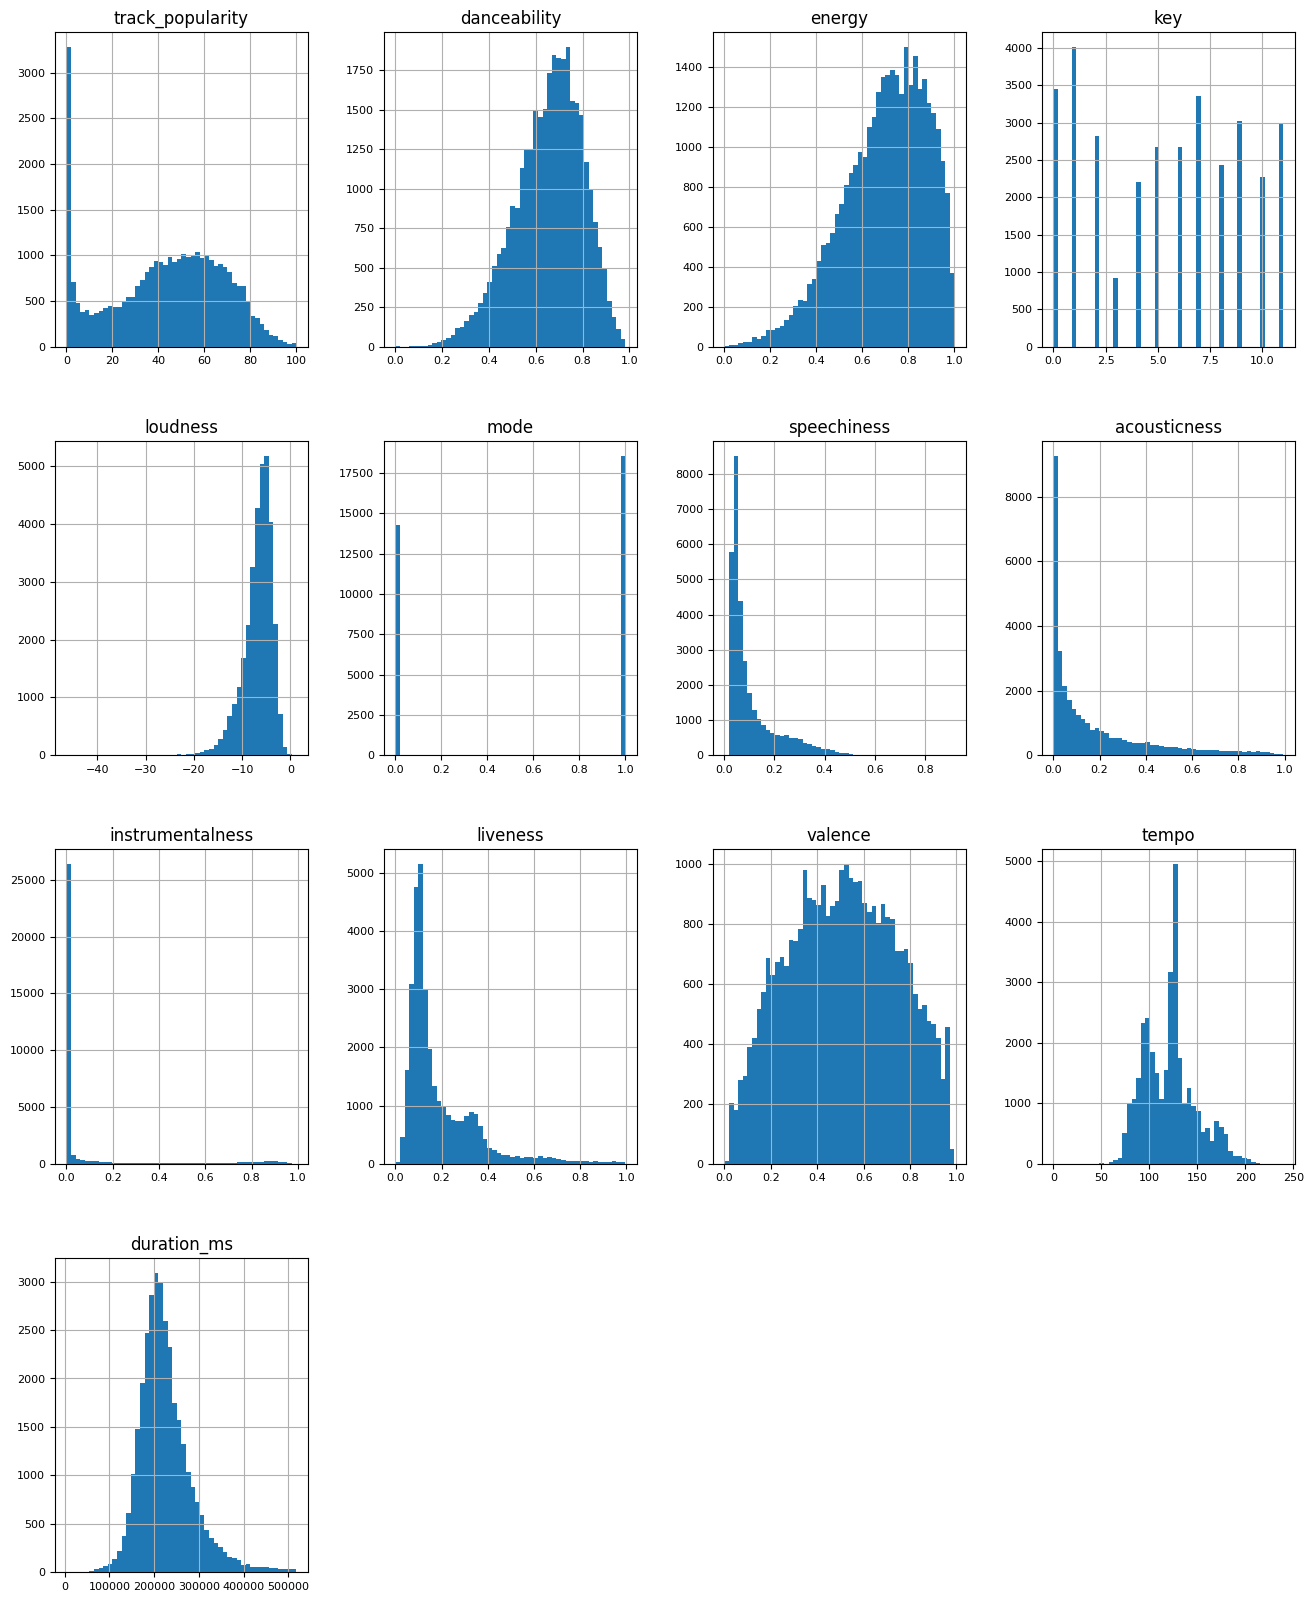

In [7]:
print("Distribución variables numéricas:")
data_num = data.select_dtypes(include = ['int64', 'float64'])
data_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

In [8]:
print("Variables categóricas:")
data_cat = data.select_dtypes(include = ['object'])
print(data_cat.columns)

Variables categóricas:
Index(['track_id', 'track_name', 'track_artist', 'track_album_id',
       'track_album_name', 'track_album_release_date', 'playlist_name',
       'playlist_id', 'playlist_genre', 'playlist_subgenre'],
      dtype='object')


playlist_genre
edm      6043
latin    5155
pop      5507
r&b      5431
rap      5746
rock     4951
dtype: int64
playlist_genre  playlist_subgenre        
edm             big room                     1206
                electro house                1511
                pop edm                      1517
                progressive electro house    1809
latin           latin hip hop                1656
                latin pop                    1262
                reggaeton                     949
                tropical                     1288
pop             dance pop                    1298
                electropop                   1408
                indie poptimism              1672
                post-teen pop                1129
r&b             hip pop                      1256
                neo soul                     1637
                new jack swing               1133
                urban contemporary           1405
rap             gangster rap                 1

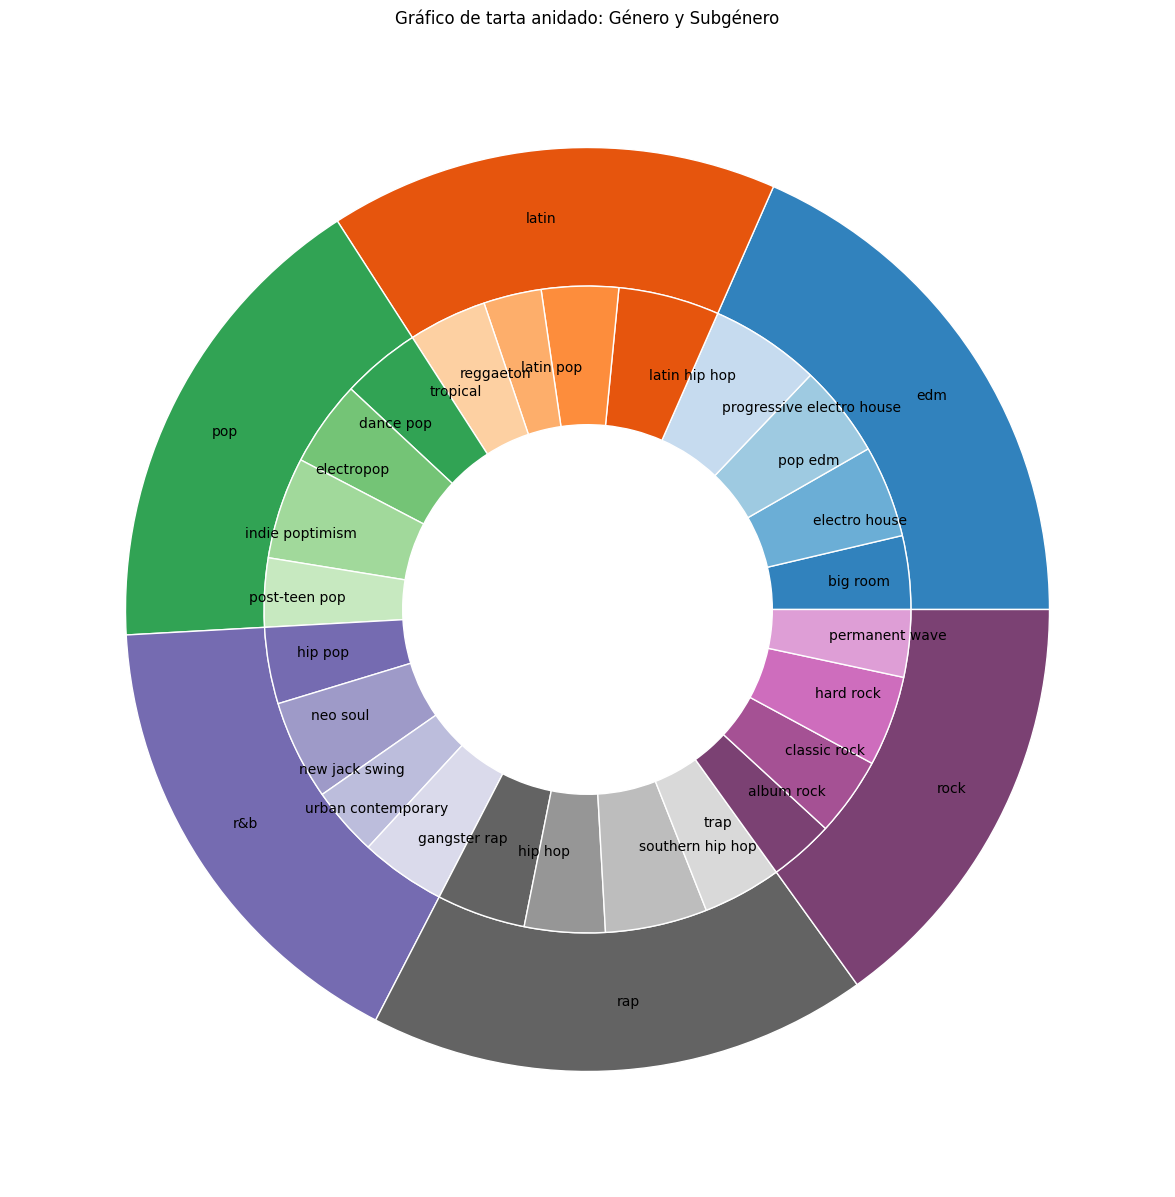

In [9]:
# 1. Agrupar por 'playlist_genre' para la capa externa y contar la cantidad de registros por género.
outer_data = data.groupby('playlist_genre').size()
print(outer_data)

# 2. Agrupar por ambas variables para la capa interna y contar la cantidad de registros por cada combinación de género y subgénero.
inner_data = data.groupby(['playlist_genre', 'playlist_subgenre']).size()
print(inner_data)

# Preparar los datos para el gráfico:
# Etiquetas y tamaños para la tarta externa (por géneros)
outer_labels = outer_data.index.tolist()
outer_sizes = outer_data.values.tolist()

# Para la tarta interna (por subgéneros) se requiere mantener el orden para asignar colores coherentes.
inner_labels = []
inner_sizes = []
# Definiremos una lista de colores para la tarta interna basados en un colormap.
colors_inner = []

# Usamos un colormap de matplotlib  para obtener colores diferenciados.
cmap = plt.get_cmap('tab20c')
cmap2 = plt.get_cmap('tab20b')
# Para la asignación de colores, definimos un índice que se irá incrementando a medida que agregamos subcategorías.
color_idx = 0

# Recorremos cada género para extraer sus subgéneros
for genre in outer_labels:
    # Seleccionar los datos del género actual
    sub_data = inner_data[genre]
    # Agregar las etiquetas de subgénero y sus cantidades
    for subgenre, count in sub_data.items():
        inner_labels.append(subgenre)
        inner_sizes.append(count)
        # Asignar un color del colormap (se puede ajustar la estrategia de asignación si se desea)
        if (color_idx < 20):
            colors_inner.append(cmap(color_idx))
        else:
            colors_inner.append(cmap2(color_idx-4))
        color_idx += 1
# Crear el gráfico
fig, ax = plt.subplots(figsize=(15, 15))

colors_outer = [cmap(i*4) for i in range(5)]
colors_outer.append(colors_inner[-4])
print(colors_outer)
# Capa externa: gráfico de tarta de géneros.
# Usamos 'wedgeprops' para definir el ancho de las "donut slices".
ax.pie(outer_sizes, radius=1, labels=outer_labels, labeldistance=0.85,
       colors=colors_outer, wedgeprops=dict(width=0.3, edgecolor='white'))

# Capa interna: gráfico de tarta de subgéneros.
# Se dibuja sobre la capa externa.
ax.pie(inner_sizes, radius=1-0.3, labels=inner_labels, labeldistance=0.75,
       colors=colors_inner, wedgeprops=dict(width=0.3, edgecolor='white'))

# Asegurar que el gráfico tiene relación de aspecto 1:1 para que sea circular.
ax.set(aspect="equal")
plt.title("Gráfico de tarta anidado: Género y Subgénero")
plt.show()

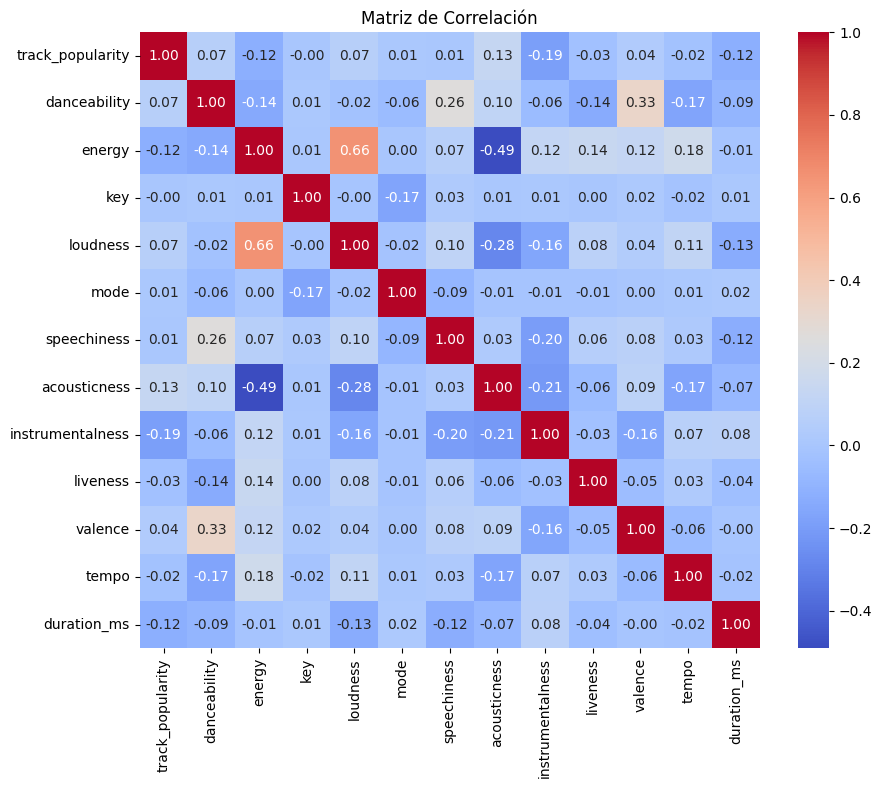

In [10]:
# Spearman
corr_matrix = data_num.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

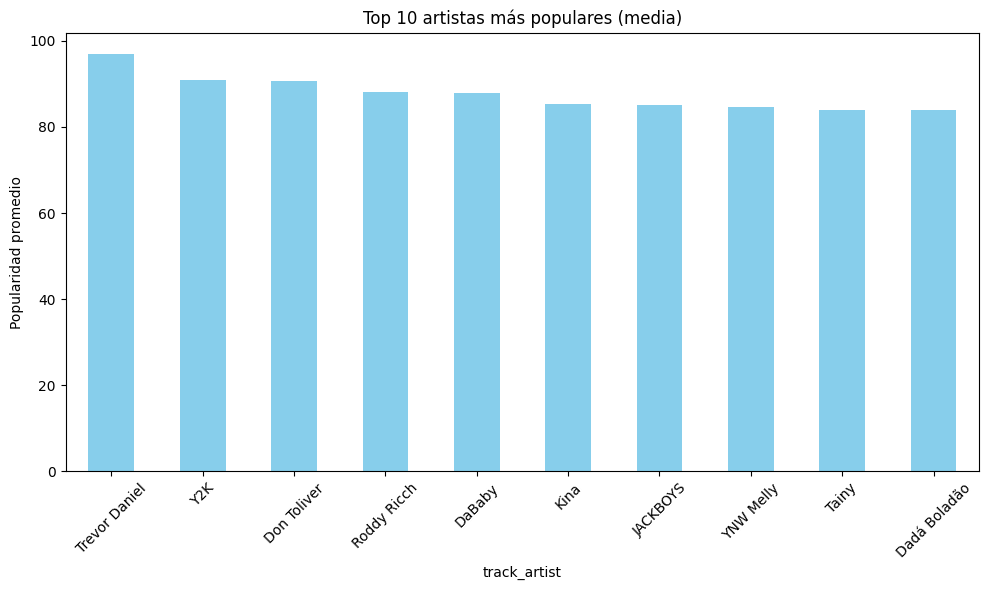

In [11]:
top_artistas = data.groupby('track_artist')['track_popularity'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
top_artistas.plot(kind='bar', color='skyblue')
plt.title('Top 10 artistas más populares (media)')
plt.ylabel('Popularidad promedio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

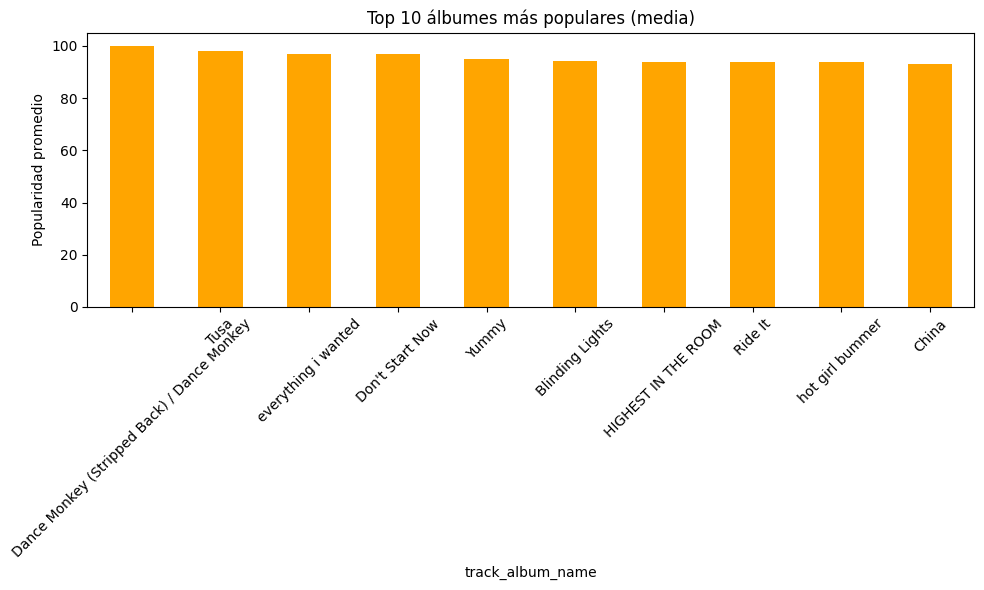

In [12]:
top_albums = data.groupby('track_album_name')['track_popularity'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
top_albums.plot(kind='bar', color='orange')
plt.title('Top 10 álbumes más populares (media)')
plt.ylabel('Popularidad promedio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


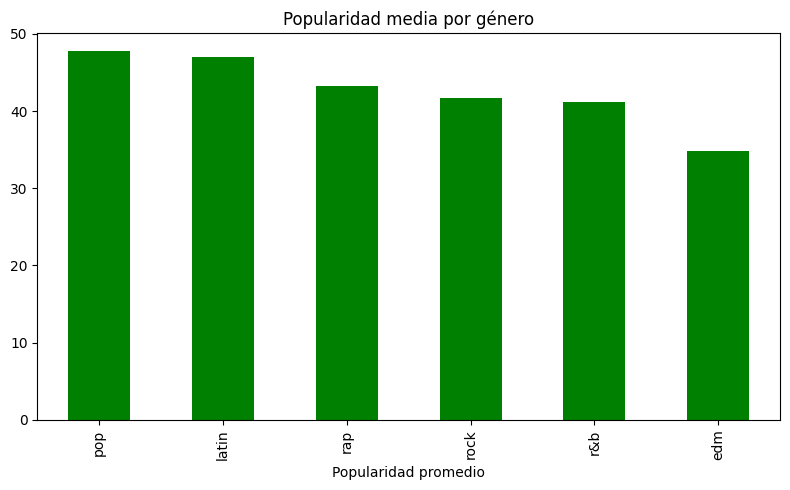

In [13]:
top_generos = data.groupby('playlist_genre')['track_popularity'].mean().sort_values(ascending=False)

plt.figure(figsize=(8,5))
top_generos.plot(kind='bar', color='green')
plt.title('Popularidad media por género')
plt.xlabel('Popularidad promedio')
plt.tight_layout()
plt.show()


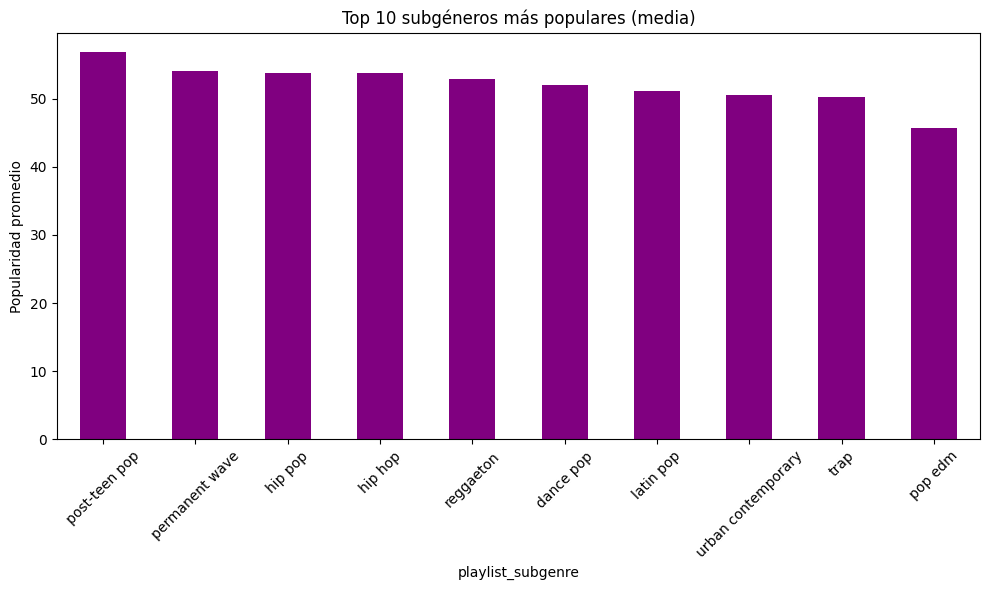

In [14]:
top_subgeneros = data.groupby('playlist_subgenre')['track_popularity'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
top_subgeneros.plot(kind='bar', color='purple')
plt.title('Top 10 subgéneros más populares (media)')
plt.ylabel('Popularidad promedio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Carga de datos con Spark

In [15]:
df = spark.read.format('csv') \
    .option('header', 'true') \
    .option('delimiter', ',') \
    .load('spotify_songs.csv') \
    .repartition(PARTS)

In [16]:
df.show(10, truncate=False) 

+----------------------+--------------------------------------+---------------------+----------------+----------------------+--------------------------------------+------------------------+--------------------------------------------------+----------------------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+
|track_id              |track_name                            |track_artist         |track_popularity|track_album_id        |track_album_name                      |track_album_release_date|playlist_name                                     |playlist_id           |playlist_genre|playlist_subgenre|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo  |duration_ms|
+----------------------+--------------------------------------+---------------------+----------------+----------------------+--------------------------------------+--------

In [17]:
df.printSchema()

root
 |-- track_id: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_artist: string (nullable = true)
 |-- track_popularity: string (nullable = true)
 |-- track_album_id: string (nullable = true)
 |-- track_album_name: string (nullable = true)
 |-- track_album_release_date: string (nullable = true)
 |-- playlist_name: string (nullable = true)
 |-- playlist_id: string (nullable = true)
 |-- playlist_genre: string (nullable = true)
 |-- playlist_subgenre: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- acousticness: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- liveness: string (nullable = true)
 |-- valence: string (nullable = true)
 |-- tempo: string (nullable = true)
 |-- duration_ms: string (nullable = true)



In [18]:
df.select('playlist_genre').distinct().show()
print("Número de géneros únicos:", df.select('playlist_genre').distinct().count())

+--------------------+
|      playlist_genre|
+--------------------+
|                 r&b|
|                 pop|
|                 edm|
|                 rap|
|                rock|
|               latin|
|1E5VdGGWkpDQ682gd...|
|4425cRh83Uzor4qCR...|
|5EMARioe9z9eKOeWI...|
|0JmBB9HfrzDiZoPVR...|
|48AzM7l4M02DBYd2N...|
| Matthias Heilbro...|
|6wyJ4bsjZaUKa9f6G...|
|37i9dQZF1DWTDafB3...|
+--------------------+

Número de géneros únicos: 14


# Preprocesado

In [19]:
# Dependencias generales
import matplotlib.pyplot as plt
import numpy as np


from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

## Asignación de los tipos correctos de las variables 

In [20]:
# Lista de columnas a convertir
cols_to_convert = [
    "track_popularity", "danceability", "energy", "key", "loudness", "mode",
    "speechiness", "acousticness", "instrumentalness", "liveness", "valence",
    "tempo", "duration_ms"
]

# Castea las columnas especificadas a DoubleType
for c in cols_to_convert:
    df = df.withColumn(c, col(c).cast(DoubleType()))

In [21]:
df.printSchema()

root
 |-- track_id: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_artist: string (nullable = true)
 |-- track_popularity: double (nullable = true)
 |-- track_album_id: string (nullable = true)
 |-- track_album_name: string (nullable = true)
 |-- track_album_release_date: string (nullable = true)
 |-- playlist_name: string (nullable = true)
 |-- playlist_id: string (nullable = true)
 |-- playlist_genre: string (nullable = true)
 |-- playlist_subgenre: string (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: double (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: double (nullable = true)



# Eliminación de instancias corruptas

Tras el análisis se han comprobado la existencia de ciertas instancias con valores corruptos en el conjunto de datos. Procedemos a eliminarlas. Para ello, se filtran únicamente las instancias que cumplen con alguno de los posibles valores  de  la variable playlist_genre (vistos en el análisis). 

In [22]:
from pyspark.sql.functions import col

valid_genres = ['pop', 'rock', 'rap', 'edm', 'r&b', 'latin']
df = df.filter(col('playlist_genre').isin(valid_genres))

In [23]:
df.select('playlist_genre').distinct().show()
print("Número de géneros únicos:", df.select('playlist_genre').distinct().count())

+--------------+
|playlist_genre|
+--------------+
|           r&b|
|           pop|
|           edm|
|           rap|
|          rock|
|         latin|
+--------------+

Número de géneros únicos: 6


## Eliminación de variables con valores únicos 

Se eliminarán las variables que tienen un valor identificador para cada canción. Las variables como: track_id, track_name, track_artist, track_album_id, track_album_name, playlist_name y playlist_id.

In [24]:
cols_to_drop = [
    'track_id', 'track_name', 'track_artist', 
    'track_album_id', 'track_album_name', 
    'playlist_name', 'playlist_id'
]

df = df.drop(*cols_to_drop)

In [25]:
from pyspark.sql.functions import monotonically_increasing_id

# Añadimos la ID al comienzo de la línea
df = df.withColumn("id", monotonically_increasing_id())

In [26]:
df.show()

+----------------+------------------------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+---+
|track_popularity|track_album_release_date|playlist_genre|playlist_subgenre|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms| id|
+----------------+------------------------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+---+
|            69.0|              2019-06-07|           rap|          hip hop|       0.951| 0.573|0.0|  -6.002| 0.0|      0.227|      0.0667|             0.0|   0.119|   0.42|105.052|   211040.0|  0|
|             0.0|              2013-09-20|           pop|       electropop|       0.723| 0.914|9.0|   -5.13| 0.0|     0.0409|      0.0862|           0.723|   0.231|  0.893|135.547|   220027.0|  1|
|         

## Aplicación de one-hot enconding de las variables categóricas

Se aplicará one-hot enconding a las variables: playlist_genre, playlist_subgenre. Y a la variable: track_album_release_date se le aplica un one-hot encoding por decada.

In [27]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

def one_hot_preprocess(df, categorical_cols):

    indexers = [StringIndexer(inputCol=col, outputCol=col + '_idx', handleInvalid='keep') for col in categorical_cols]
    encoders = [OneHotEncoder(inputCol=col + '_idx', outputCol=col + '_ohe') for col in categorical_cols]

    pipeline = Pipeline(stages=indexers + encoders)
    return  pipeline.fit(df).transform(df)

In [28]:
categorical_cols = ['playlist_genre']
df = one_hot_preprocess(df, categorical_cols= categorical_cols)

In [29]:
df.select('playlist_genre', 'playlist_genre_ohe').show(10, truncate=False)

+--------------+------------------+
|playlist_genre|playlist_genre_ohe|
+--------------+------------------+
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
+--------------+------------------+
only showing top 10 rows



In [30]:
from pyspark.sql.functions import substring

# Extraer el año de la fecha (formato 'YYYY-MM-DD')
df = df.withColumn("release_year", substring("track_album_release_date", 1, 4).cast("int")).cache()

In [31]:
# Guardamos las variables 'playlist_genre' y 'playlist_subgenre' en otro dataframe
# Nota: serán útiles más tarde para comparar con los resultados del Clustering
df_var_saved = df.select('id', 'playlist_genre', 'playlist_subgenre')

print(df.show())

# Eliminación de variables transformadas y retiradas
df = df.drop('playlist_genre', 'playlist_subgenre', 'track_album_release_date')

+----------------+------------------------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+---+------------------+------------------+------------+
|track_popularity|track_album_release_date|playlist_genre|playlist_subgenre|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms| id|playlist_genre_idx|playlist_genre_ohe|release_year|
+----------------+------------------------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+---+------------------+------------------+------------+
|            69.0|              2019-06-07|           rap|          hip hop|       0.951| 0.573|0.0|  -6.002| 0.0|      0.227|      0.0667|             0.0|   0.119|   0.42|105.052|   211040.0|  0|               1.0|     (6,[1],[1.0])|        2019|
|   

In [32]:
# Mostramos variables guardadas
df_var_saved.show(truncate=False)

+---+--------------+-----------------+
|id |playlist_genre|playlist_subgenre|
+---+--------------+-----------------+
|0  |rap           |hip hop          |
|1  |pop           |electropop       |
|2  |rock          |permanent wave   |
|3  |rock          |album rock       |
|4  |rock          |album rock       |
|5  |pop           |indie poptimism  |
|6  |pop           |post-teen pop    |
|7  |rock          |classic rock     |
|8  |rap           |hip hop          |
|9  |rap           |southern hip hop |
|10 |pop           |indie poptimism  |
|11 |pop           |dance pop        |
|12 |rap           |hip hop          |
|13 |rock          |album rock       |
|14 |rock          |album rock       |
|15 |pop           |electropop       |
|16 |pop           |indie poptimism  |
|17 |rap           |gangster rap     |
|18 |rock          |classic rock     |
|19 |pop           |indie poptimism  |
+---+--------------+-----------------+
only showing top 20 rows



In [33]:
idx_cols = [col + '_idx' for col in categorical_cols]
df = df.drop(*idx_cols)

In [34]:
df.show(20, truncate=False)

+----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+---+------------------+------------+
|track_popularity|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo  |duration_ms|id |playlist_genre_ohe|release_year|
+----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+---+------------------+------------+
|69.0            |0.951       |0.573 |0.0|-6.002  |0.0 |0.227      |0.0667      |0.0             |0.119   |0.42   |105.052|211040.0   |0  |(6,[1],[1.0])     |2019        |
|0.0             |0.723       |0.914 |9.0|-5.13   |0.0 |0.0409     |0.0862      |0.723           |0.231   |0.893  |135.547|220027.0   |1  |(6,[2],[1.0])     |2013        |
|0.0             |0.681       |0.893 |0.0|-3.519  |1.0 |0.037      |0.178       |0.0             |0.213   |0.815  |123.651|205132.0   |2  |(

### Modificar la representación de one-hot Sparse Vector a columnas convencionales 

Explicar muy bien porque hemos pensado en cierto punto de la implemetación cambiar a columnas convencionales.

## Estandarización

In [35]:
columnas = df.columns

if "id" in columnas:
    columnas.remove("id")

In [36]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Ensamblar todas los atributos en un único vector dentro de una sola columna
assembler = VectorAssembler(inputCols=columnas, outputCol="features")
df = assembler.transform(df)

# Ajuste de la estandarización
scaler = StandardScaler(
    inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

# Eliminar la columna 'features'
df = df.drop('features')

df.show(20, truncate=False)

25/04/24 02:24:31 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+---+------------------+------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|track_popularity|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo  |duration_ms|id |playlist_genre_ohe|release_year|scaled_features                                                                                                                                                                                                                                                 

## Aplicación de reducción de la dimensionalidad

### Análisis de la varianza explicada de las componentes

In [37]:
from pyspark.ml.feature import PCA

# Obtener el tamaño del vector en la columna 'features'
vector_size = df.select("scaled_features").first()[0].size

pca = PCA(k = vector_size, inputCol="scaled_features", outputCol="pca_features") 
pca_model = pca.fit(df)

25/04/24 02:24:32 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/04/24 02:24:32 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
25/04/24 02:24:32 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
25/04/24 02:24:32 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


[0.12425651 0.23617776 0.32277568 0.39915552 0.46728501 0.5270107
 0.58343955 0.63857329 0.68729757 0.73344538 0.77645893 0.81722258
 0.8578004  0.89051726 0.92105821 0.95006117 0.97077572 0.98966445
 1.         1.        ]


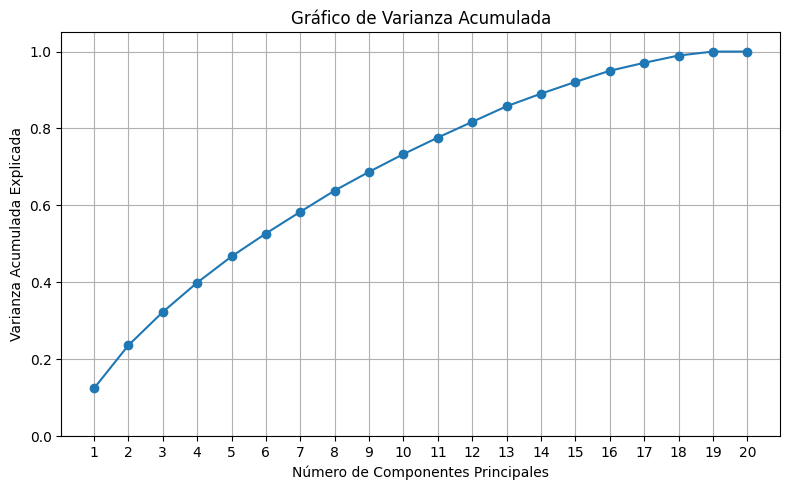

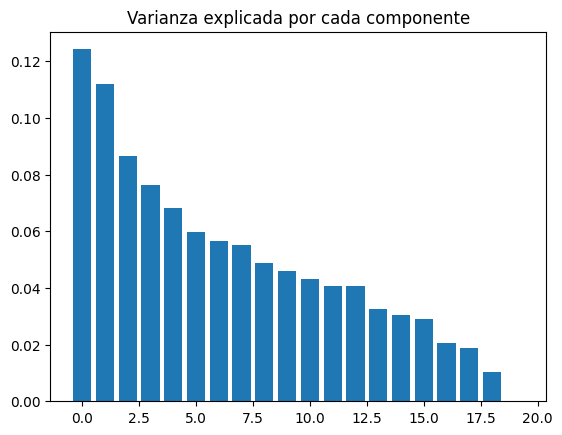

In [38]:
explained_variance = pca_model.explainedVariance.toArray()
cumulative_variance = np.cumsum(explained_variance)
print(cumulative_variance)

# Visualizar varianza acumulada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulada Explicada')
plt.title('Gráfico de Varianza Acumulada')
plt.grid(True)
plt.ylim(0, 1.05)
plt.xticks(range(1, len(cumulative_variance) + 1))
plt.tight_layout()
plt.show()

# Visualizar varianza explicada por cada componente
plt.bar(range(explained_variance.shape[0]), explained_variance/np.sum(explained_variance))
plt.title('Varianza explicada por cada componente')
plt.show()

### Reducción de la dimensionalidad con PCA

In [39]:
# Cantidad de componentes principales a conservar

# Ajustar el modelo de PCA
pca = PCA(k = DIMS, inputCol="scaled_features", outputCol="pca_features") 
pca_model = pca.fit(df)

# Transformar el dataframe
df = pca_model.transform(df)

# Eliminar la variable de 'scaled_features'
pca_data = df.drop('scaled_features')

In [40]:
pca_data.show(20, truncate=False)

+----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+---+------------------+------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|track_popularity|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo  |duration_ms|id |playlist_genre_ohe|release_year|pca_features                                                                                                                                                                                                                                                                             |
+----------------+------------+------+---+--------+----+-----------+------------+-----------

# Código de DBScan original

In [41]:
from pyspark.sql import Row
import math
from graphframes import *
from itertools import combinations

def __distance_from_pivot(pivot, dist, epsilon, operations):
    """
    Genera una función que asigna un punto a una partición según su distancia al pivote.

    :param pivot: Valor del pivote para calcular distancias.
    :param dist: Función de distancia que toma dos valores y retorna una distancia numérica.
    :param epsilon: Umbral de distancia para crear particiones.
    :param operations: (Opcional) Objeto para contar operaciones de distancia, con método `add()`.
    :return: Función que toma un objeto `x` y retorna una lista de tuplas con índice de partición y lista de `Row`s.
    """
    def distance(x):
        pivot_dist = dist(x.value, pivot)
        if operations is not None:
            operations.add()
        partition_index = math.floor(pivot_dist / epsilon)
        rows = [Row(id=x.id, value=x.value, pivot_dist=dist(x.value, pivot))]
        out = [(partition_index, rows),
               (partition_index + 1, rows)]
        return out
    return distance


def __scan(epsilon, dist, operations):
    """
    Genera una función que identifica vecinos dentro de una partición que están a menos de `epsilon` de distancia.

    :param epsilon: Distancia máxima para considerar dos puntos como vecinos.
    :param dist: Función de distancia entre puntos.
    :param operations: (Opcional) Objeto para contar operaciones de distancia.
    :return: Función que toma una tupla con índice de partición y datos, y retorna lista de `Row`s con vecinos.
    """

    def scan(x):
        # El diccionario de salida tiene un ID de punto como clave y un conjunto de IDs de los puntos a una distancia 
        # menor a epsilon. value contiene a los vecinos
        out = {}
        # El índice 0 es el índice de partición
        # El índice 1 son los datos
        partition_data = x[1]
        partition_len = len(partition_data)
        for i in range(partition_len):
            for j in range(i + 1, partition_len):
                if operations is not None:
                    operations.add()
                if dist(partition_data[i].value, partition_data[j].value) < epsilon:
                    # Tanto i como j están a una distancia menor a epsilon
                    if partition_data[i].id in out:
                        out[partition_data[i].id].add(partition_data[j].id)
                    else:
                        out[partition_data[i].id] = set([partition_data[j].id])
                    if partition_data[j].id in out:
                        out[partition_data[j].id].add(partition_data[i].id)
                    else:
                        out[partition_data[j].id] = set([partition_data[i].id])
        # Devuelve un punto y sus vecinos como tupla
        return [Row(item[0], item[1]) for item in out.items()]

    return scan


def __label(min_pts):
    """
    Genera una función que etiqueta puntos como núcleos o puntos base según el número de vecinos.

    :param min_pts: Número mínimo de puntos (incluyendo el mismo) para ser considerado punto núcleo.
    :return: Función que toma una tupla (id, vecinos) y retorna una lista de tuplas (id, [(etiqueta, es_núcleo)]).
    """
    def label(x):
        if len(x[1]) + 1 >= min_pts:
            # Usar ID como etiqueta de cluster
            cluster_label = x[0]
            # Se devuelve True para los puntos núcleo
            out = [(x[0], [(cluster_label, True)])]
            for idx in x[1]:
                # Se devuelve False para los puntos base
                out.append((idx, [(cluster_label, False)]))
            return out
        return []

    return label

def __combine_labels(x):
    """
    Combina múltiples etiquetas de clúster para un punto y determina si es un punto núcleo.

    :param x: Tupla donde el primer elemento es el id del punto, y el segundo es una lista de (etiqueta, es_núcleo).
    :return: Tupla (id, etiquetas de clúster, es_núcleo) con todas las etiquetas si es núcleo, o solo una si no lo es.
    """
    # El elemento 0 es el ID del punto
    # El elemento 1 es una lista de tuplas con cluster y estiqueta de núcleo
    point = x[0]
    core_point = False
    cluster_labels = x[1]
    clusters = []
    for (label, point_type) in cluster_labels:
        if point_type is True:
            core_point = True
        clusters.append(label)
    # if core point keep all cluster otherwise only one
    return point, clusters if core_point is True else [clusters[0]], core_point


def process(spark, df, epsilon, min_pts, dist, dim, checkpoint_dir, operations=None):
    """
    Process given dataframe with DBSCAN parameters
    :param spark: spark session
    :param df: input data frame where each row has id and value keys
    :param epsilon: DBSCAN parameter for distance
    :param min_pts: DBSCAN parameter for minimum points to define core point
    :param dist: method to calculate distance. Only distance metric is supported.
    :param dim: number of dimension of input data
    :param checkpoint_dir: checkpoint path as required by Graphframe
    :param operations: class for managing accumulator to calculate number of distance operations
    :return: A dataframe of point id, cluster component and boolean indicator for core point
    """
    zero = df.rdd.takeSample(False, 1)[0].value
    combine_cluster_rdd = df.rdd.\
        flatMap(__distance_from_pivot(zero, dist, epsilon, operations)). \
        reduceByKey(lambda x, y: x + y).\
        flatMap(__scan(epsilon, dist, operations)). \
        reduceByKey(lambda x, y: x.union(y)).\
        flatMap(__label(min_pts)).\
        reduceByKey(lambda x, y: x + y).map(__combine_labels).cache()
    id_cluster_rdd = combine_cluster_rdd.\
        map(lambda x: Row(point=x[0], cluster_label=x[1][0], core_point=x[2]))
    try:
        id_cluster_df = id_cluster_rdd.toDF()
        vertices = combine_cluster_rdd.\
            flatMap(lambda x: [Row(id=item)
                    for item in x[1]]).toDF().distinct()
        edges = combine_cluster_rdd. \
            flatMap(lambda x: [Row(src=item[0], dst=item[1])
                               for item in combinations(x[1], 2)]). \
            toDF().distinct()
        spark.sparkContext.setCheckpointDir(checkpoint_dir)
        g = GraphFrame(vertices, edges)
        connected_df = g.connectedComponents()
        id_cluster_df = id_cluster_df.\
            join(connected_df, connected_df.id == id_cluster_df.cluster_label). \
            select("point", "component", "core_point")
        return id_cluster_df
    except ValueError:
        return None

In [42]:
df_pca = pca_data.select("id","pca_features")
df_preproc = df_pca.sample(withReplacement=False, fraction=FRAC, seed=123456)

# Renombramos la columna por un nombre genérico como value
df_preproc = df_preproc.withColumnRenamed("pca_features", "value").cache()

# Mostrar el resultado
df_preproc.show(truncate=False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id |value                                                                                                                                                                                                                                                                                    |
+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0  |[-0.49701377399306346,2.6596176960991906,-0.3841709310884234,-1.3936637880426939,0.9432916386462072,-0.34499713338318955,0.84760411

In [43]:
# Ejecución del algoritmo
df_clusters = process(spark, df_preproc, 2, 20,
                      distance.euclidean, DIMS, "checkpoint")

25/04/24 02:54:22 WARN BlockManager: Task 235 already completed, not releasing lock for rdd_206_0
25/04/24 02:54:22 WARN BlockManager: Task 236 already completed, not releasing lock for rdd_206_0


In [44]:
np.unique(np.array(df_clusters.toPandas()["component"]), return_counts=True)

(array([          0,           2,           5,          10,          20,
                 25,          43,         959,        1466,        1470,
               1474,        1478,  8589934619, 25769804469]),
 array([2286, 5411, 1980, 2884, 1092, 2619, 1997,   58, 2934, 2293, 2449,
        2739,   42,   23]))

In [45]:
np.sum(np.unique(np.array(df_clusters.toPandas()
       ["component"]), return_counts=True)[1])

28807

In [46]:
df_joined = df_preproc.join(df_clusters, df_preproc.id == df_clusters.point)
df_joined

DataFrame[id: bigint, value: vector, point: bigint, component: bigint, core_point: boolean]

In [47]:
df_results = df_joined.select("id", "value", "component").toPandas()
df_results

,id,value,component
0,42949674814,"[1.7189668478058133, 0.6778932646793945, 0.145...",1478
1,1785,"[2.0662874846046826, 0.927916992326909, 0.0064...",1478
2,25769805702,"[1.8774388761582896, 1.0304836881421233, 0.119...",1478
3,68719479294,"[1.0132457689671717, 1.109936957792571, 0.7735...",1478
4,77309413372,"[1.7606717863701604, 0.7052555907642496, 0.934...",1478
...,...,...,...
28802,25769805170,"[0.2235166882918732, -4.482832171790176, -1.24...",20
28803,51539608595,"[-1.013769959238291, -3.705466051490611, -0.37...",2
28804,60129543080,"[0.4163852735581873, -0.9639831363290287, -0.0...",25
28805,85899346289,"[0.5296197407586289, 0.6741776560829957, -1.25...",25


In [48]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

X = np.array(df_results['value'].tolist())

# Crear un modelo PCA para reducir a 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Crear un modelo TSNE para reducir a 2 componentes
tsne = TSNE(n_components=2, random_state=123456, n_jobs=-1)
X_tsne = tsne.fit_transform(X)

# Agregar las componentes principales al DataFrame de Pandas
df_results['pca1'] = X_pca[:, 0]
df_results['pca2'] = X_pca[:, 1]
df_results['tsne1'] = X_tsne[:, 0]
df_results['tsne2'] = X_tsne[:, 1]

In [49]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def plot_result(dataset, result_tags, file_name=None, style='ticks'):

    # data preparation
    dataset = np.array(dataset)
    df = pd.DataFrame()
    df['x'] = dataset[:, 0]
    df['y'] = dataset[:, 1]
    df['label'] = result_tags

    # sns preparation
    sns.set_style(style)
    f, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

    # Plot raw points (without labels)
    sns.scatterplot(x='x', y='y', data=df, ax=axes[0], color='blue')
    axes[0].set_title('Puntos sin etiquetar')

    # Plot clustered points
    sns.scatterplot(x='x', y='y', data=df, hue='label',
                    ax=axes[1], palette='tab20')
    axes[1].set_title('Resultado del clustering')

    for ax in axes:
        ax.set_xlabel('x')
        ax.set_ylabel('y')

    if file_name:
        f.suptitle(f'DBSCAN Result of {file_name}', fontsize=14)

    plt.tight_layout()
    plt.show()

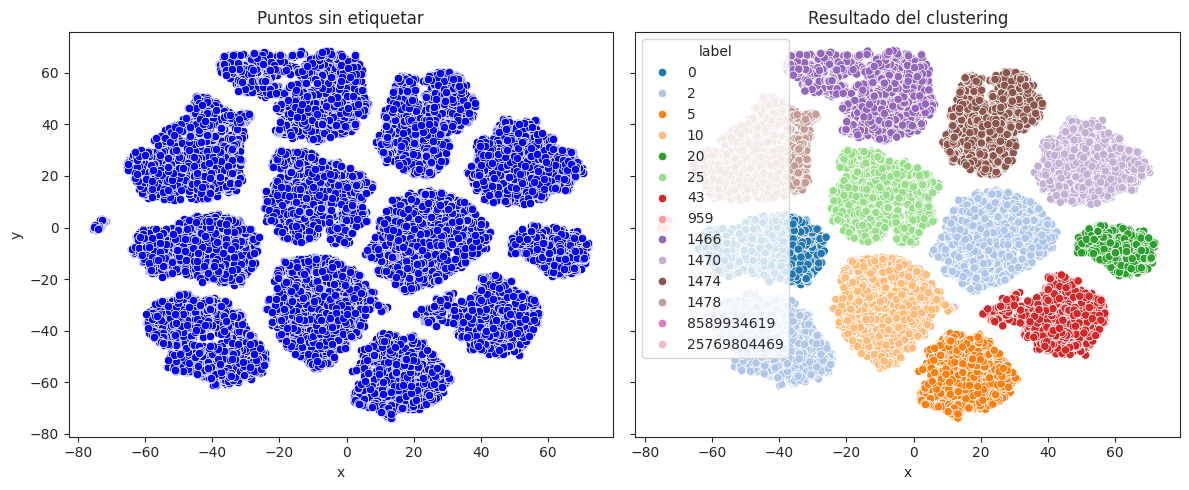

In [50]:
plot_result(X_tsne, df_results["component"])

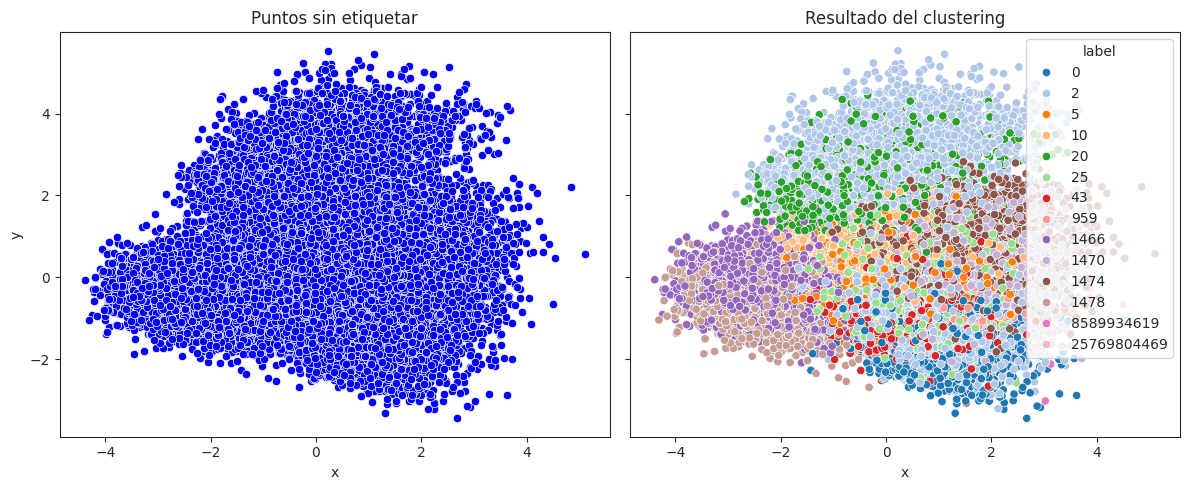

In [51]:
plot_result(X_pca, df_results["component"])

In [52]:
df_var_saved.show()

+---+--------------+-----------------+
| id|playlist_genre|playlist_subgenre|
+---+--------------+-----------------+
|  0|           rap|          hip hop|
|  1|           pop|       electropop|
|  2|          rock|   permanent wave|
|  3|          rock|       album rock|
|  4|          rock|       album rock|
|  5|           pop|  indie poptimism|
|  6|           pop|    post-teen pop|
|  7|          rock|     classic rock|
|  8|           rap|          hip hop|
|  9|           rap| southern hip hop|
| 10|           pop|  indie poptimism|
| 11|           pop|        dance pop|
| 12|           rap|          hip hop|
| 13|          rock|       album rock|
| 14|          rock|       album rock|
| 15|           pop|       electropop|
| 16|           pop|  indie poptimism|
| 17|           rap|     gangster rap|
| 18|          rock|     classic rock|
| 19|           pop|  indie poptimism|
+---+--------------+-----------------+
only showing top 20 rows



In [53]:
df_results

,id,value,component,pca1,pca2,tsne1,tsne2
0,42949674814,"[1.7189668478058133, 0.6778932646793945, 0.145...",1478,-1.498966,-0.872338,-54.327881,29.546375
1,1785,"[2.0662874846046826, 0.927916992326909, 0.0064...",1478,-1.693560,-1.214773,-54.685966,29.418011
2,25769805702,"[1.8774388761582896, 1.0304836881421233, 0.119...",1478,-1.544572,-1.277992,-54.673145,29.473713
3,68719479294,"[1.0132457689671717, 1.109936957792571, 0.7735...",1478,-0.967210,-1.278035,-56.384846,29.956518
4,77309413372,"[1.7606717863701604, 0.7052555907642496, 0.934...",1478,-1.734884,-1.087879,-53.786274,27.103289
...,...,...,...,...,...,...,...
28802,25769805170,"[0.2235166882918732, -4.482832171790176, -1.24...",20,-0.831593,4.343434,60.119549,-9.793698
28803,51539608595,"[-1.013769959238291, -3.705466051490611, -0.37...",2,0.079974,3.962679,28.101700,-6.696592
28804,60129543080,"[0.4163852735581873, -0.9639831363290287, -0.0...",25,-0.548621,0.806391,1.602445,9.438599
28805,85899346289,"[0.5296197407586289, 0.6741776560829957, -1.25...",25,0.079365,-0.688331,5.748284,2.348934


In [54]:
df_var_saved = df_var_saved.withColumnRenamed("id", "point")
df_subgeneros = df_var_saved
df_etiq_subgeneros = df_clusters.select("point").join(df_subgeneros, on="point", how="inner")
df_etiq_subgeneros = df_etiq_subgeneros.toPandas()


In [55]:
df_etiq_subgeneros.sort_values(by="point")

,point,playlist_genre,playlist_subgenre
12194,0,rap,hip hop
26937,2,rock,permanent wave
4213,4,rock,album rock
24487,5,pop,indie poptimism
24455,6,pop,post-teen pop
...,...,...,...
4557,94489283242,edm,big room
26127,94489283243,edm,progressive electro house
9312,94489283244,edm,pop edm
10025,94489283245,latin,latin hip hop


In [56]:
df_subgeneros = df_subgeneros.toPandas()

In [57]:
df_subgeneros

,point,playlist_genre,playlist_subgenre
0,0,rap,hip hop
1,1,pop,electropop
2,2,rock,permanent wave
3,3,rock,album rock
4,4,rock,album rock
...,...,...,...
32816,94489283242,edm,big room
32817,94489283243,edm,progressive electro house
32818,94489283244,edm,pop edm
32819,94489283245,latin,latin hip hop


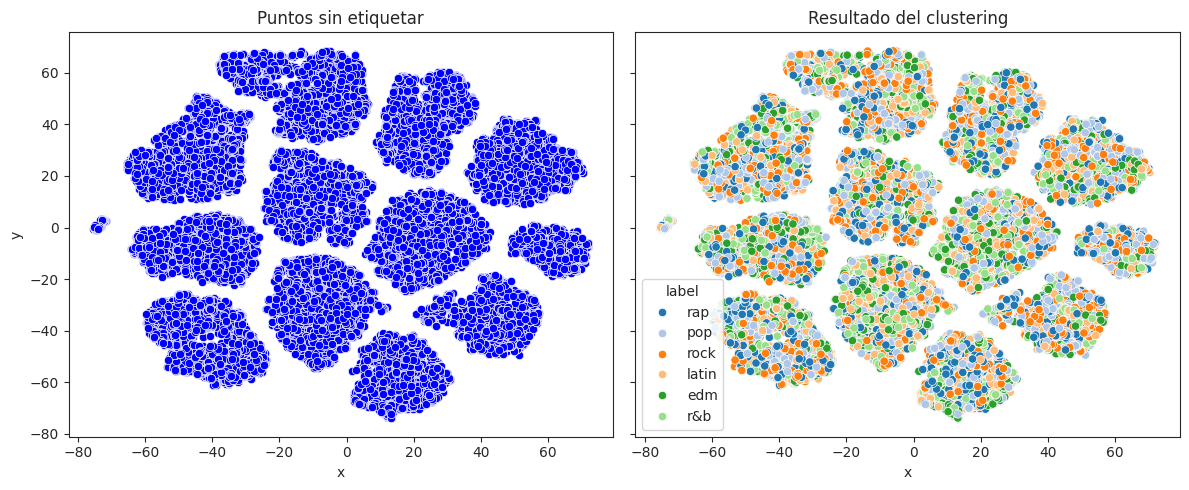

In [58]:
plot_result(X_tsne, df_subgeneros["playlist_genre"])

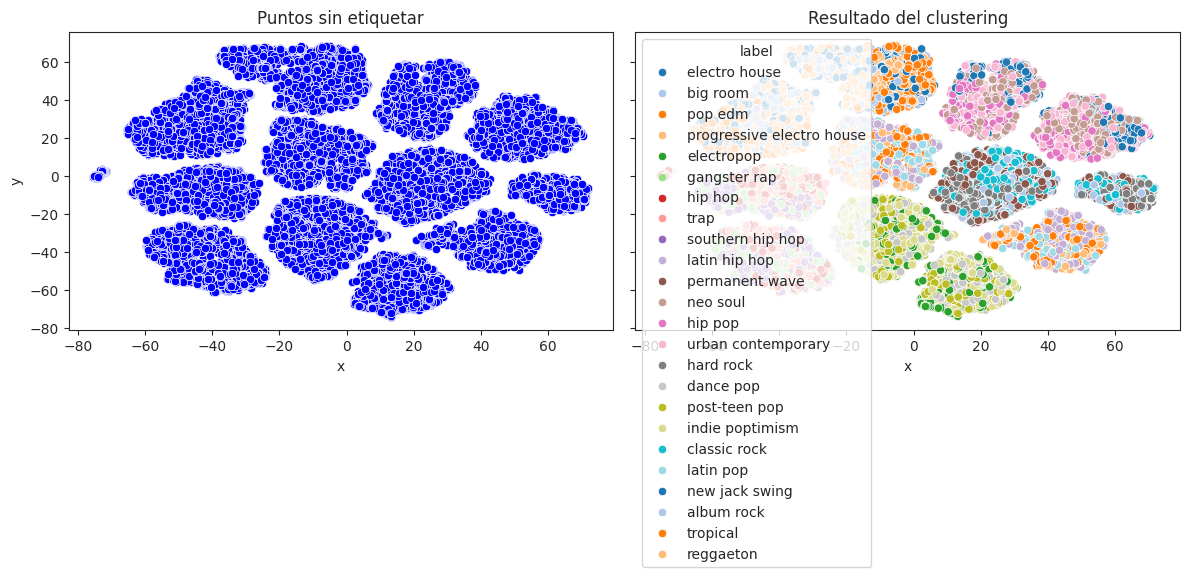

In [59]:
plot_result(X_tsne, df_etiq_subgeneros["playlist_subgenre"])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=97fa435b-89c8-4b22-a4df-60f2ff3508a1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>